<a href="https://colab.research.google.com/github/Venura-Shiromal/NASA-Space-Apps-2025/blob/main/TOI_ClassificationModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# just in case if needed
# !pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.1 MB/s eta 0:00:00


## Prerequisities

In [4]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

## Loading Data

In [18]:
toi = pd.read_csv('sample_data/TOI_2025.09.26_07.08.49.csv', comment='#')
toi.head()

,toi,tid,tfopwg_disp,rastr,ra,decstr,dec,st_pmra,st_pmraerr1,st_pmraerr2,...,st_logg,st_loggerr1,st_loggerr2,st_logglim,st_rad,st_raderr1,st_raderr2,st_radlim,toi_created,rowupdate
0,1000.01,50365310,FP,07h29m25.85s,112.357708,-12d41m45.46s,-12.695960,-5.964,0.085,-0.085,...,4.19,0.07,-0.07,0,2.16986,0.072573,-0.072573,0.0,2019-07-24 15:58:33,2024-09-09 10:08:01
1,1001.01,88863718,PC,08h10m19.31s,122.580465,-05d30m49.87s,-5.513852,-4.956,0.102,-0.102,...,4.03,0.09,-0.09,0,2.01000,0.090000,-0.090000,0.0,2019-07-24 15:58:33,2023-04-03 14:31:04
2,1002.01,124709665,FP,06h58m54.47s,104.726966,-10d34m49.64s,-10.580455,-1.462,0.206,-0.206,...,NaN,NaN,NaN,0,5.73000,NaN,NaN,0.0,2019-07-24 15:58:33,2022-07-11 16:02:02
3,1003.01,106997505,FP,07h22m14.39s,110.559945,-25d12m25.26s,-25.207017,-0.939,0.041,-0.041,...,4.15,1.64,-1.64,0,NaN,NaN,NaN,0.0,2019-07-24 15:58:33,2022-02-23 10:10:02
4,1004.01,238597883,FP,08h08m42.77s,122.178195,-48d48m10.12s,-48.802811,-4.496,0.069,-0.069,...,4.14,0.07,-0.07,0,2.15000,0.060000,-0.060000,0.0,2019-07-24 15:58:33,2024-09-09 10:08:01


## Feature Selection

In [19]:
features = [
    "pl_orbper",
    "pl_trandurh",
    "pl_trandep",
    "pl_rade",
    "pl_eqt",
    "pl_insol",
    "st_teff",
    "st_logg",
    "st_rad",
    "st_tmag",
    "st_dist",
    "st_raderr1",
    "st_raderr2",
    "st_pmra",
    "st_pmdec",

    "tfopwg_disp"
    ]

In [20]:
toi = toi[features]

Label Mapping

In [21]:
label_map = {
    "CP": 1,   # Confirmed Planet
    "KP": 1,   # Known Planet
    "PC": 0,   # Planetary Candidate
    "APC": 0,  # Ambiguous Planetary Candidate
    "FP": -1,  # False Positive
    "FA": -1   # False Alarm
}

toi["tfopwg_disp"] = toi["tfopwg_disp"].map(label_map)

## Filling empty cells

In [22]:
numerical_cols = ["pl_orbper","pl_trandurh","pl_trandep","pl_rade",
                  "pl_insol","pl_eqt","st_teff","st_logg","st_rad", "st_tmag",
                  "st_dist", "st_raderr1", "st_raderr2", "st_pmra", "st_pmdec"]

for col in numerical_cols:
    toi[col].fillna(toi[col].mean(), inplace=True)


/tmp/ipython-input-1443849499.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  toi[col].fillna(toi[col].mean(), inplace=True)


### Checking if NaN available

In [24]:
print(toi.isna().sum())

pl_orbper      0
pl_trandurh    0
pl_trandep     0
pl_rade        0
pl_eqt         0
pl_insol       0
st_teff        0
st_logg        0
st_rad         0
st_tmag        0
st_dist        0
st_raderr1     0
st_raderr2     0
st_pmra        0
st_pmdec       0
tfopwg_disp    0
dtype: int64


## Defining data sets

In [26]:
X = toi.drop("tfopwg_disp", axis=1)
y = toi["tfopwg_disp"]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
    )

Defining Classes

In [28]:
classes = np.unique(y_train)

Calculating Class Weights

In [29]:
weights = compute_class_weight("balanced", classes=classes, y=y_train)

Combining both

In [30]:
class_weights = dict(zip(classes, weights))

### Cross-validation

In [31]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, valid_idx in skf.split(X, y):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

## Cat Boost Initiation

### Parameters


In [32]:
max_ite = 2500
dep = 8
l_rate = 0.04

In [33]:
model = CatBoostClassifier(
    iterations=max_ite,
    depth=dep,
    learning_rate=l_rate,
    loss_function="MultiClass",
    eval_metric="MultiClass",
    l2_leaf_reg=7,
    early_stopping_rounds=50,
    random_seed=42,
    verbose=50,
    class_weights=class_weights
)


# Training

In [34]:
model.fit(X_train, y_train, eval_set=(X_test, y_test))

0:	learn: 1.0858927	test: 1.0857926	best: 1.0857926 (0)	total: 84.8ms	remaining: 3m 32s
50:	learn: 0.8367024	test: 0.8403127	best: 0.8403127 (50)	total: 1.83s	remaining: 1m 27s
100:	learn: 0.7503315	test: 0.7565413	best: 0.7565413 (100)	total: 3.61s	remaining: 1m 25s
150:	learn: 0.6970178	test: 0.7081768	best: 0.7081768 (150)	total: 5.47s	remaining: 1m 25s
200:	learn: 0.6526313	test: 0.6696133	best: 0.6696133 (200)	total: 8.38s	remaining: 1m 35s
250:	learn: 0.6144585	test: 0.6375966	best: 0.6375966 (250)	total: 10.1s	remaining: 1m 30s
300:	learn: 0.5824345	test: 0.6089472	best: 0.6089472 (300)	total: 11.9s	remaining: 1m 27s
350:	learn: 0.5527202	test: 0.5851939	best: 0.5851939 (350)	total: 13.7s	remaining: 1m 23s
400:	learn: 0.5260037	test: 0.5635044	best: 0.5635044 (400)	total: 15.5s	remaining: 1m 21s
450:	learn: 0.5000945	test: 0.5432340	best: 0.5432340 (450)	total: 17.3s	remaining: 1m 18s
500:	learn: 0.4773791	test: 0.5247028	best: 0.5247028 (500)	total: 20s	remaining: 1m 19s
550:	l

### Plotting Loss

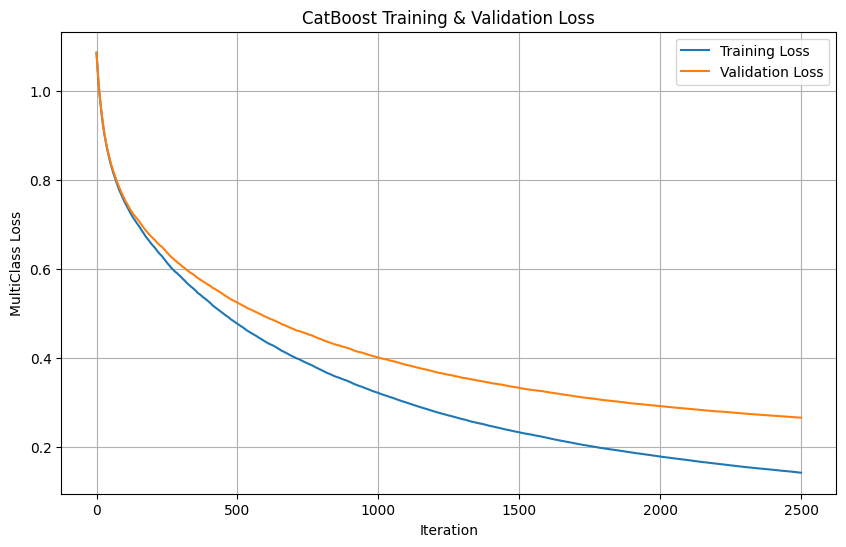

In [35]:
evals_result = model.get_evals_result()

train_loss = evals_result['learn']['MultiClass']
valid_loss = evals_result['validation']['MultiClass']

# Plot
plt.figure(figsize=(10,6))
plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('MultiClass Loss')
plt.title('CatBoost Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation

In [36]:
y_pred = model.predict(X_test)

### Confusion Matrix

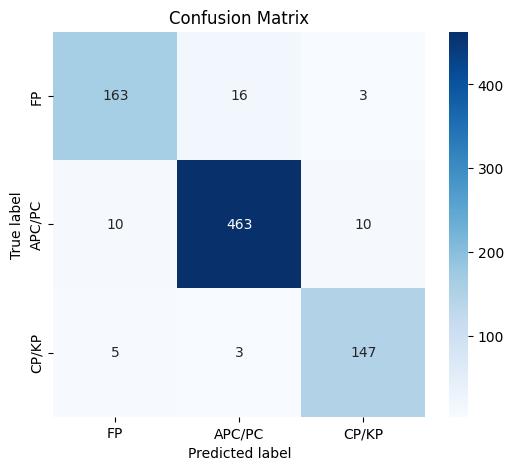

In [37]:
cm = confusion_matrix(y_test, y_pred)

class_names = ["FP", "APC/PC", "CP/KP"]

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

Accuracy

In [38]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(acc * 100))

Accuracy: 94.27%
